<a href="https://colab.research.google.com/github/Jalalbaim/Auto-Encoder/blob/main/Variational_Auto_Encoder_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational auto encoder**
BAIM Mohamed Jalal
***


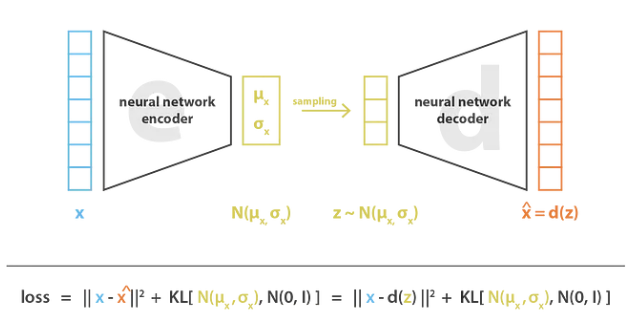

## **Libraries:**
***

In [81]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn, optim
from tqdm import tqdm
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [82]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## **Datasets: Fashion Mnist & Mnist**
***

### **Fashion MNIST**


In [83]:
# Dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [84]:
# Labels
label_index = training_data.targets[0]
label_name = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
][label_index]

print("Label index:", label_index)
print("Label name:", label_name)

Label index: tensor(9)
Label name: Ankle boot


In [85]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


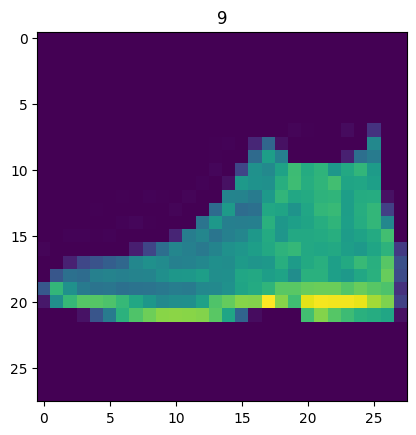

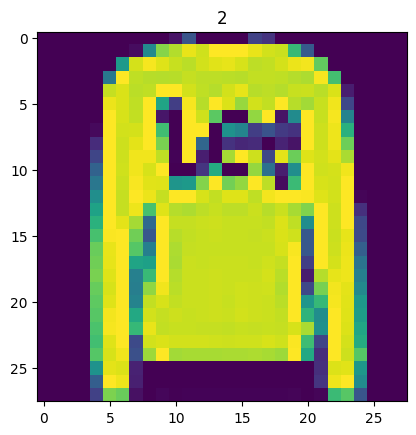

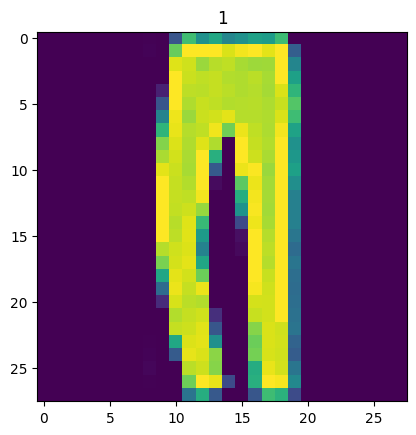

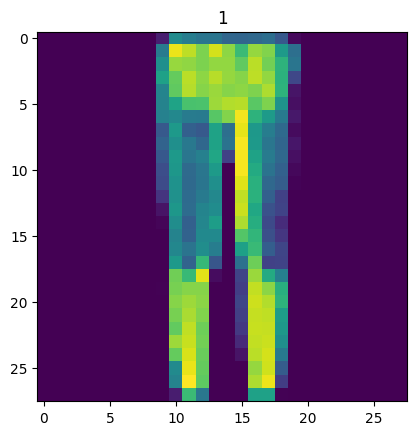

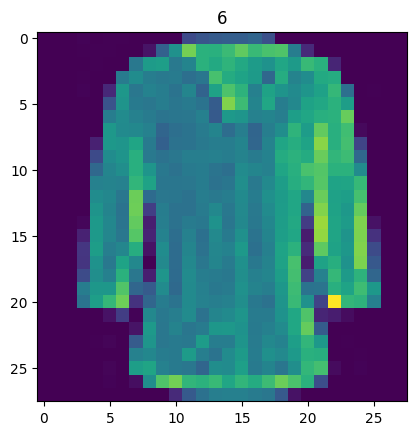

In [86]:
# visualization de Fashion MNIST
for i in range(5):
  image, label = test_data[i]
  plt.imshow(image.cpu().reshape(28,28))
  plt.title(label)
  plt.axis('on')
  plt.show()

### **MNIST**


In [87]:
# Dataset
training_data_MNIST = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data_MNIST = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [88]:
batch_size = 64

train_dataloader_MNIST = DataLoader(training_data_MNIST, batch_size=batch_size)
test_dataloader_MNIST = DataLoader(test_data_MNIST, batch_size=batch_size)

for X, y in test_dataloader_MNIST:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


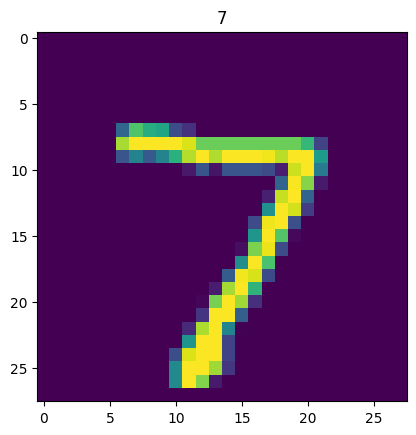

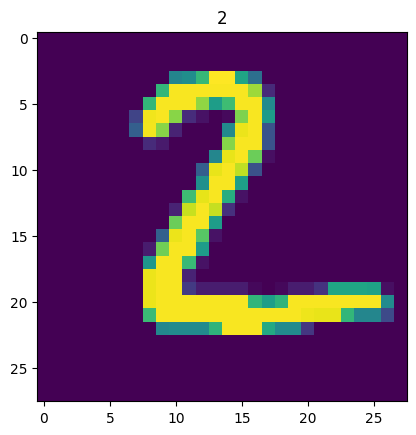

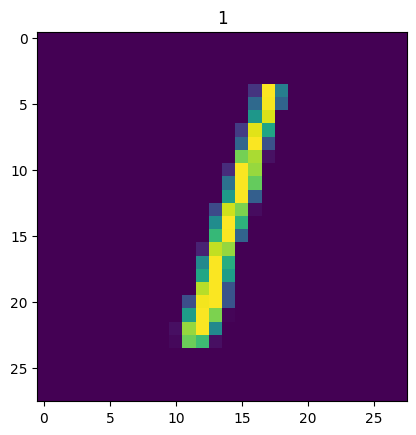

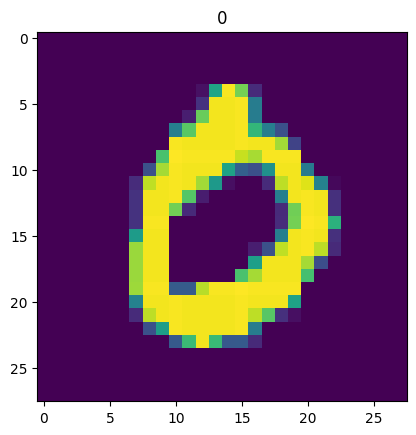

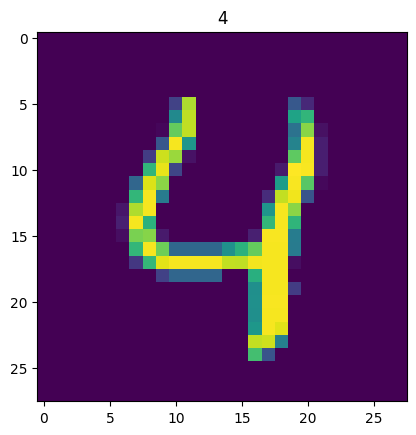

In [89]:
# Visualisation de quelques images de la base de données
for i in range(5):
  image, label = test_data_MNIST[i]
  plt.imshow(image.cpu().reshape(28,28))
  plt.title(label)
  plt.axis('on')
  plt.show()

## **Variational auto encoder VAE**
***

In [90]:
class VAE_base(nn.Module):
    def __init__(self, encoder, decoder, latent_dim):
        super(VAE_base, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def forward(self, x):
        encoded = self.encoder(x)
        z_mean = encoded[:, :self.latent_dim]
        z_log_var = encoded[:, self.latent_dim:]
        z = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(z)
        return decoded, z_mean, z_log_var, z

    def reparameterize(self, z_mean, z_log_var):
        std =  torch.sqrt(torch.exp(z_log_var))
        eps = torch.randn_like(std)
        return z_mean + eps * std

class VAutoEncoder(VAE_base):
    def __init__(self, input_dim, latent_dim):
        encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 2 * latent_dim)
        )
        decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )
        super(VAutoEncoder, self).__init__(encoder=encoder, decoder=decoder, latent_dim=latent_dim)


In [91]:
def loss_fn(decoded, x, z_mean, z_log_var):
    """
    Fonction loss
    """
    batch_size = x.size(0)

    # assurer le log
    decoded = torch.clamp(decoded, 1e-8, 1 - 1e-8)

    # mean square error MSE
    recon_loss = F.mse_loss(decoded, x, reduction='sum') / batch_size

    # KL divergence
    kl_divergence = 0.5 * torch.sum(
        torch.exp(z_log_var) + z_mean**2 - 1. - z_log_var
    ) / batch_size

    # Total loss
    total_loss = recon_loss + kl_divergence

    return total_loss, recon_loss, kl_divergence

In [92]:
def train_vae(model, dataloader, optimizer, loss_fn, device, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward
        decoded, z_mean, z_log_var, z = model(data)
        decoded_reshaped = decoded.view_as(data)

        # loss
        total_loss, recon_loss, kl_divergence = loss_fn(decoded_reshaped, data, z_mean, z_log_var)

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {total_loss.item():.6f}')

    average_loss = train_loss / len(dataloader)
    print(f"Average Loss: {average_loss:.4f}")
    return average_loss

In [93]:
# visualize reconstruction
def visualize_reconstructions(model, dataloader, num_images=5):
    """
    La fonction permet de visualiser la reconstruction des images en entrée
    """
    model.eval()
    figure, axes = plt.subplots(2, num_images, figsize=(10, 4))

    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            if i >= num_images:
                break
            data = data.to(next(model.parameters()).device)
            reconstruction, _, _, _ = model(data.view(data.size(0), -1))

            original = data.view(data.shape[0], 28, 28)
            recon = reconstruction.view(reconstruction.shape[0], 28, 28)

            ax = axes[0, i]
            ax.imshow(original[i].cpu().numpy())
            ax.axis('off')
            ax.set_title('Original')

            ax = axes[1, i]
            ax.imshow(recon[i].cpu().numpy())
            ax.axis('off')
            ax.set_title('Reconstructed')

    plt.show()

### Visualisation de l'espace latent


 **1.  PCA (Ananlyse composante principale):** \\
PCA est une technique de réduction de dimensionnalité qui identifie les axes (composantes principales) le long desquels les données varient le plus. \\
**2.   t-SNE (t-Distributed Stochastic Neighbor Embedding):** \\
La t-SNE convertit les similarités entre les points de données en probabilités jointes et essaie de minimiser la divergence de Kullback-Leibler entre les probabilités jointes des données à faible dimension et celles à haute dimension, favorisant ainsi la formation de petits clusters locaux dans l'espace réduit. \\

**3. Visualisation avec Variance**


In [94]:
def visualize_latent_space(model, dataloader, device, method='pca'):
    """
    Visualise l'espace latent d'un modèle VAE utilisant PCA ou t-SNE.

    Args:
    - method: Méthode de réduction de dimension ('pca' ou 'tsne').
    """
    model.eval()
    z_means = []
    labels = []

    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(device)
            _, z_mean, _, _ = model(data)
            z_means.append(z_mean)
            labels.append(label)

    z_means = torch.cat(z_means).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    if method == 'pca':
        pca = PCA(n_components=2)
        z_reduced = pca.fit_transform(z_means)
    elif method == 'tsne':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
        z_reduced = tsne.fit_transform(z_means)
    else:
        raise ValueError("Méthode non supportée. Utilisez 'pca' ou 'tsne'.")

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_reduced[:, 0], z_reduced[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(f'Visualisation de l\'espace latent avec {method.upper()}')
    plt.xlabel('Composante 1')
    plt.ylabel('Composante 2')
    plt.grid(True)
    plt.show()


In [95]:
def visualize_latent_space_with_variance_fixed(model, dataloader, device):
    """
    Visualisation l'espace latent d'un modèle VAE utilisant PCA ou t-SNE, avec la taille des points proportionnelle à la variance
    """
    model.eval()
    data, _ = next(iter(dataloader))
    data = data.to(device)
    with torch.no_grad():
        _, z_mean, z_log_var, _ = model(data)

    z_var = torch.exp(z_log_var)

    point_sizes = z_var.cpu().numpy() * 1500

    plt.figure(figsize=(6, 4))
    plt.scatter(z_mean.cpu().numpy()[:, 0], z_mean.cpu().numpy()[:, 1], s=point_sizes[:, 0])
    plt.xlabel('Dimension Latente 1')
    plt.ylabel('Dimension Latente 2')
    plt.title('Visualisation de l\'Espace Latent')
    plt.grid(True)
    plt.show()

### Visualisation des échantillons générés

In [96]:
def generate_samples_from_prior(decoder, latent_dim, num_samples, device, n_row = 2, n_col = 5):
    """
    Je génère des échantillons à partir de la distribution a priori en utilisant le décodeur.
    Cette fonction prend en entrée le décodeur, la dimension latente, le nombre d'échantillons à générer.
    """
    z_prior = torch.randn(num_samples, latent_dim).to(device)
    generated_samples = decoder(z_prior)
    samples = generated_samples.cpu().detach().numpy()

    fig, axes = plt.subplots(n_row, n_col, figsize=(n_col * 3, n_row * 3))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.suptitle("Generated samples from prior")
    plt.show()


def generate_samples_from_posterior(model, data, device, n_row=2, n_col=5):
    """
    Je génère des échantillons à partir de la distribution a posteriori qui est
    la distribution des variables latentes conditionnée par les données p(z|x).
    Cette fonction prend en entrée le modèle VAE et les données d'entrée.

    Output:  échantillons générés qui ne correspondent pas directement aux
    entrées originales mais sont des nouvelles instances générées basées sur
    une distribution apprise.
    """
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        data = data.view(data.size(0), -1)
        _, z_mean, z_log_var, _ = model(data)
        z = model.reparameterize(z_mean, z_log_var)
        reconstructed_data = model.decoder(z)

    samples = reconstructed_data.cpu().numpy()

    fig, axes = plt.subplots(n_row, n_col, figsize=(n_col * 3, n_row * 3))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.suptitle("Generated samples from posterior")
    plt.show()


## **Application du VAE sur Fashion MNIST**
***

In [97]:
vae_FMNIST = VAutoEncoder(28*28, 2).to(device) # Dimension de l'espace latent == 2
dataloader = train_dataloader
optimizer = optim.Adam(vae_FMNIST.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
  print("--------------------------")
  print(f"Epoch {epoch}")
  train_vae(vae_FMNIST, dataloader, optimizer, loss_fn, device ,epoch)


--------------------------
Epoch 0
Epoch: 0 [0/60000 (0%)]	Loss: 140.669266
Epoch: 0 [6400/60000 (11%)]	Loss: 36.840103
Epoch: 0 [12800/60000 (21%)]	Loss: 35.335892
Epoch: 0 [19200/60000 (32%)]	Loss: 31.765182
Epoch: 0 [25600/60000 (43%)]	Loss: 35.220924
Epoch: 0 [32000/60000 (53%)]	Loss: 34.120174
Epoch: 0 [38400/60000 (64%)]	Loss: 29.779631
Epoch: 0 [44800/60000 (75%)]	Loss: 30.241013
Epoch: 0 [51200/60000 (85%)]	Loss: 32.108181
Epoch: 0 [57600/60000 (96%)]	Loss: 30.568659
Average Loss: 36.2003
--------------------------
Epoch 1
Epoch: 1 [0/60000 (0%)]	Loss: 32.196556
Epoch: 1 [6400/60000 (11%)]	Loss: 30.054457
Epoch: 1 [12800/60000 (21%)]	Loss: 31.974815
Epoch: 1 [19200/60000 (32%)]	Loss: 29.730701
Epoch: 1 [25600/60000 (43%)]	Loss: 32.149658
Epoch: 1 [32000/60000 (53%)]	Loss: 32.673336
Epoch: 1 [38400/60000 (64%)]	Loss: 28.059492
Epoch: 1 [44800/60000 (75%)]	Loss: 29.118389
Epoch: 1 [51200/60000 (85%)]	Loss: 30.971556
Epoch: 1 [57600/60000 (96%)]	Loss: 29.232784
Average Loss: 31.53

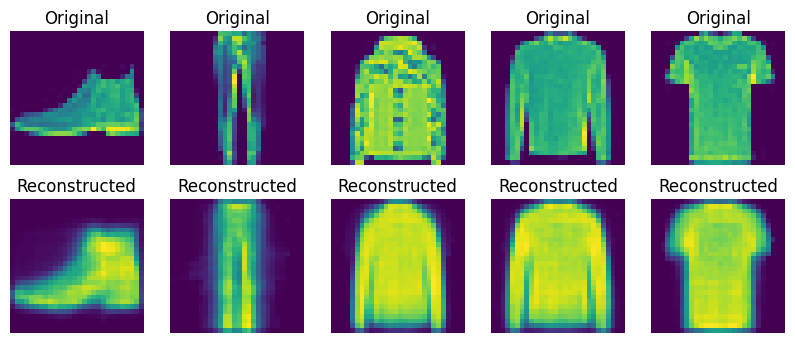

In [98]:
# visualisation sur Fashion MNIST
visualize_reconstructions(vae_FMNIST, test_dataloader)

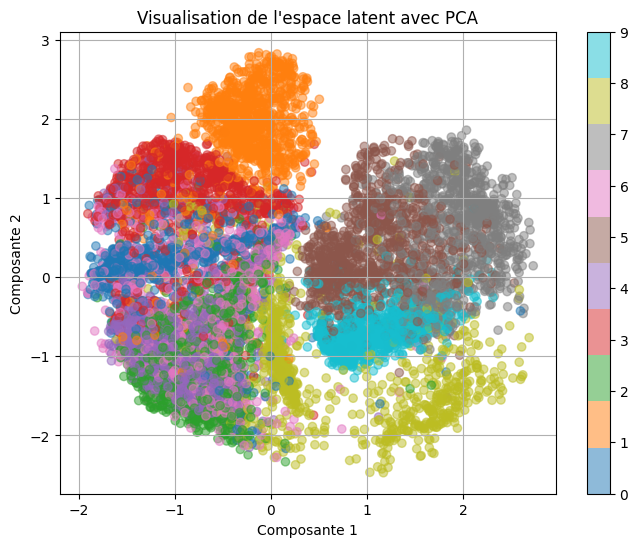

In [99]:
visualize_latent_space(vae_FMNIST, test_dataloader, device ,method='pca')

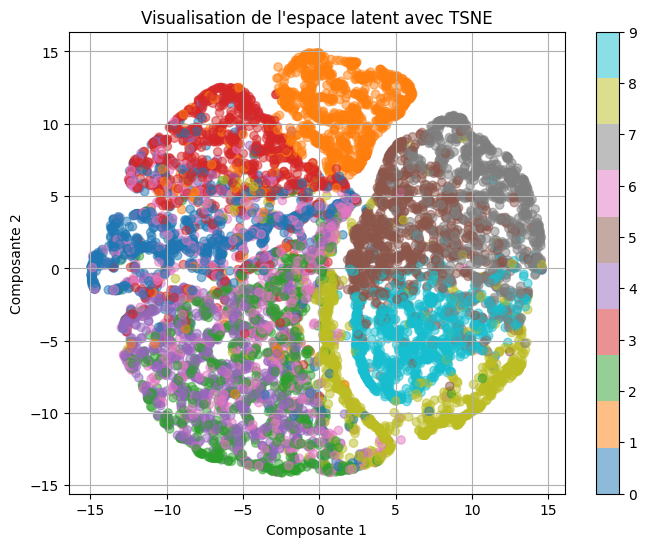

In [100]:
visualize_latent_space(vae_FMNIST, test_dataloader, device,method='tsne')

### **Commentaire sur la visualisation de l'espace latent**
Le graphique t-SNE montre une séparation nette des clusters. En comparaison, le PCA présente une superposition des clusters ce qui illustrela capacité du t-SNE à mieux capturer les relations locales non linéaires par rapport au PCA, qui maximise la variance globale.

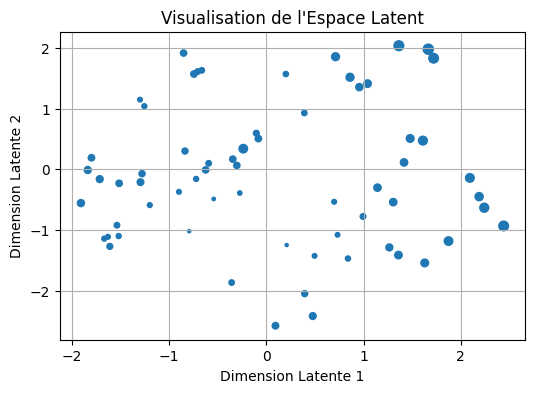

In [101]:
visualize_latent_space_with_variance_fixed(vae_FMNIST, test_dataloader, device)

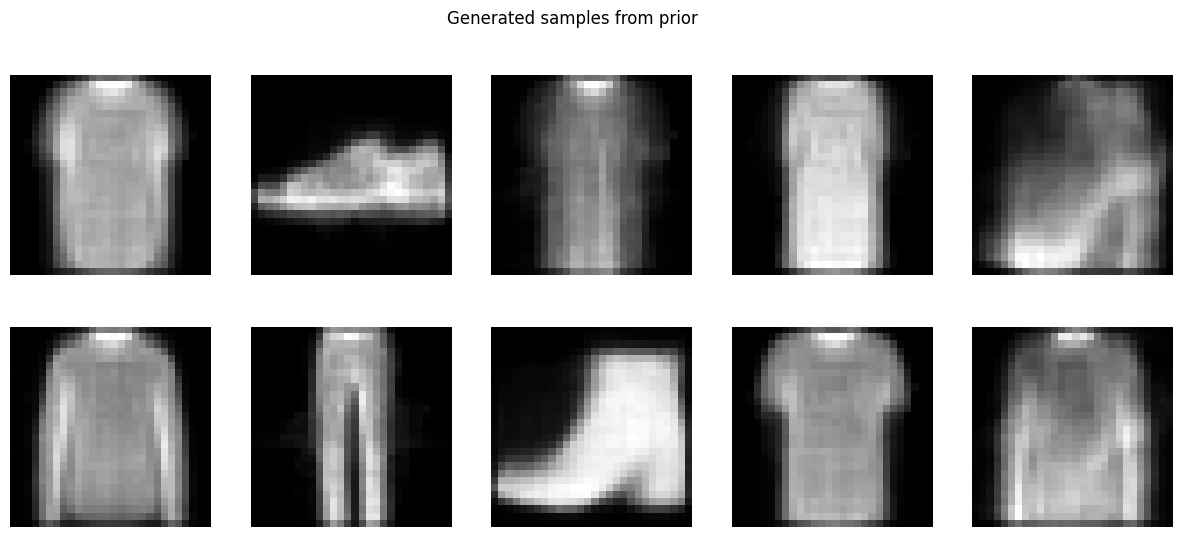

In [102]:
generate_samples_from_prior(vae_FMNIST.decoder, 2,10, device, 2,5)

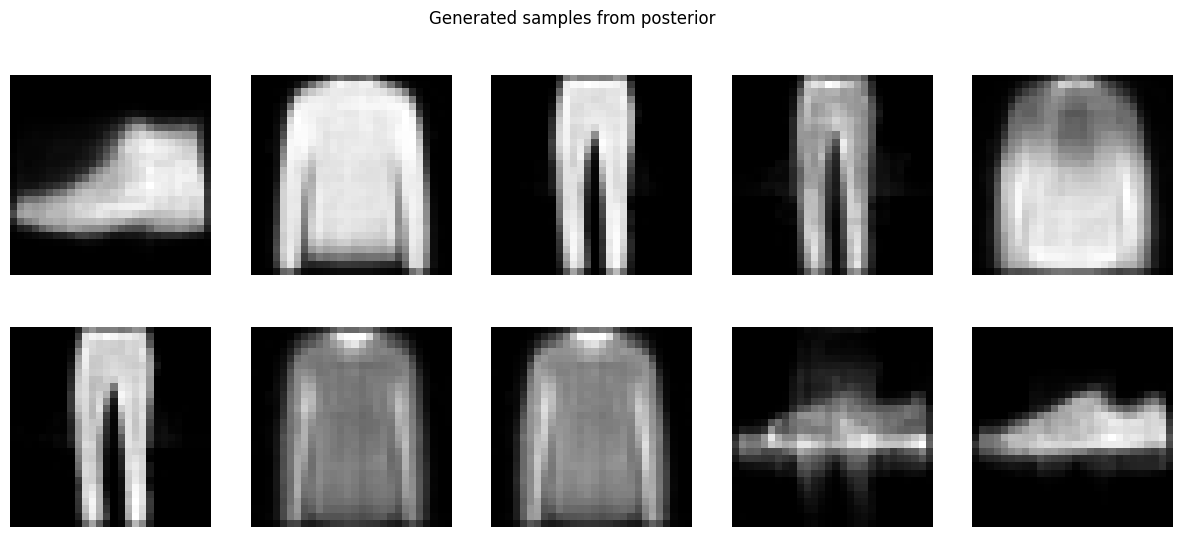

In [103]:
num_samples = 10
data = next(iter(test_dataloader))[0][:num_samples]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

generate_samples_from_posterior(vae_FMNIST, data, device, 2, 5)

### Commentaires sur les images générées:

Certaines images sont claires et bien formées, ce qui indique que ces régions de l'espace latent capturent bien les caractéristiques sous-jacentes des données. Cependant, quelques images semblent un peu floues ou moins définies, ce qui peut indiquer soit des régions moins bien modélisées de l'espace latent, soit des échantillons tirés de régions de faible probabilité.

## **Application du VAE sur MNIST**
***

In [104]:
vae_MNIST = VAutoEncoder(28*28, 2).to(device) # Dimension de l'espace latent == 2
dataloader = train_dataloader_MNIST
optimizer = optim.Adam(vae_MNIST.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
  print("--------------------------")
  print(f"Epoch {epoch}")
  train_vae(vae_MNIST, dataloader, optimizer, loss_fn, device ,epoch)

--------------------------
Epoch 0
Epoch: 0 [0/60000 (0%)]	Loss: 184.954865
Epoch: 0 [6400/60000 (11%)]	Loss: 52.090591
Epoch: 0 [12800/60000 (21%)]	Loss: 45.290440
Epoch: 0 [19200/60000 (32%)]	Loss: 50.827915
Epoch: 0 [25600/60000 (43%)]	Loss: 45.004032
Epoch: 0 [32000/60000 (53%)]	Loss: 44.986626
Epoch: 0 [38400/60000 (64%)]	Loss: 40.480694
Epoch: 0 [44800/60000 (75%)]	Loss: 43.215393
Epoch: 0 [51200/60000 (85%)]	Loss: 48.067314
Epoch: 0 [57600/60000 (96%)]	Loss: 42.431084
Average Loss: 47.3651
--------------------------
Epoch 1
Epoch: 1 [0/60000 (0%)]	Loss: 41.364017
Epoch: 1 [6400/60000 (11%)]	Loss: 43.046745
Epoch: 1 [12800/60000 (21%)]	Loss: 40.134899
Epoch: 1 [19200/60000 (32%)]	Loss: 47.245106
Epoch: 1 [25600/60000 (43%)]	Loss: 41.895016
Epoch: 1 [32000/60000 (53%)]	Loss: 42.740219
Epoch: 1 [38400/60000 (64%)]	Loss: 39.793388
Epoch: 1 [44800/60000 (75%)]	Loss: 41.098312
Epoch: 1 [51200/60000 (85%)]	Loss: 45.900070
Epoch: 1 [57600/60000 (96%)]	Loss: 40.756996
Average Loss: 42.25

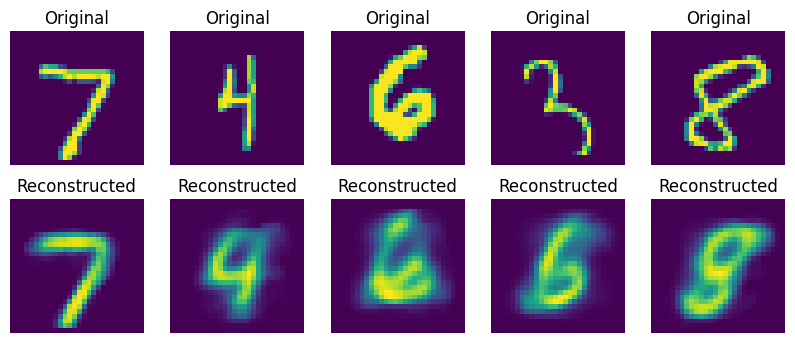

In [105]:
# Reconstruction
visualize_reconstructions(vae_MNIST, test_dataloader_MNIST)

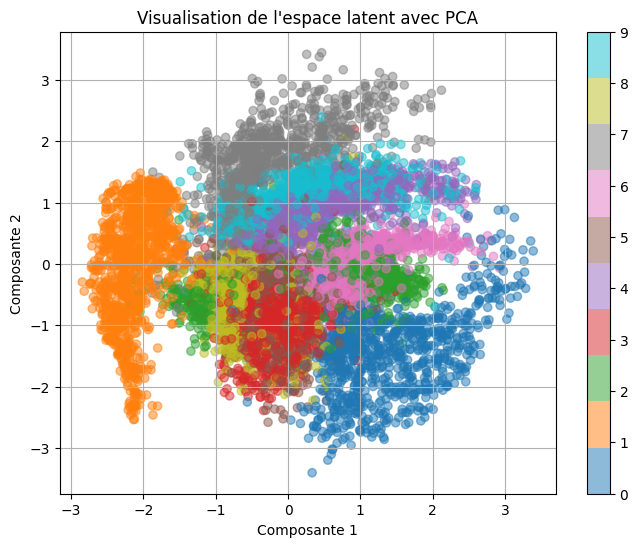

In [106]:
# Latent space avec pca
visualize_latent_space(vae_MNIST, test_dataloader_MNIST, device, method='pca')

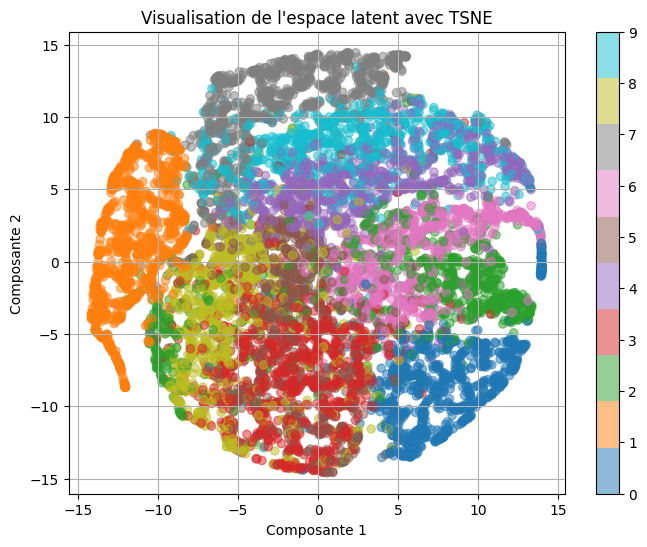

In [107]:
# Latent space avec tsne
visualize_latent_space(vae_MNIST, test_dataloader_MNIST, device, method='tsne')

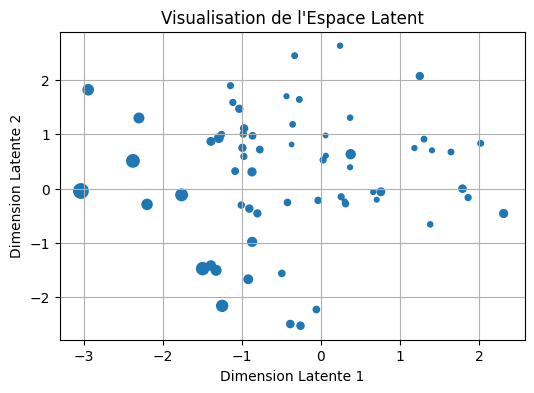

In [108]:
# Latent space en fonction de la variance
visualize_latent_space_with_variance_fixed(vae_MNIST, test_dataloader_MNIST, device)

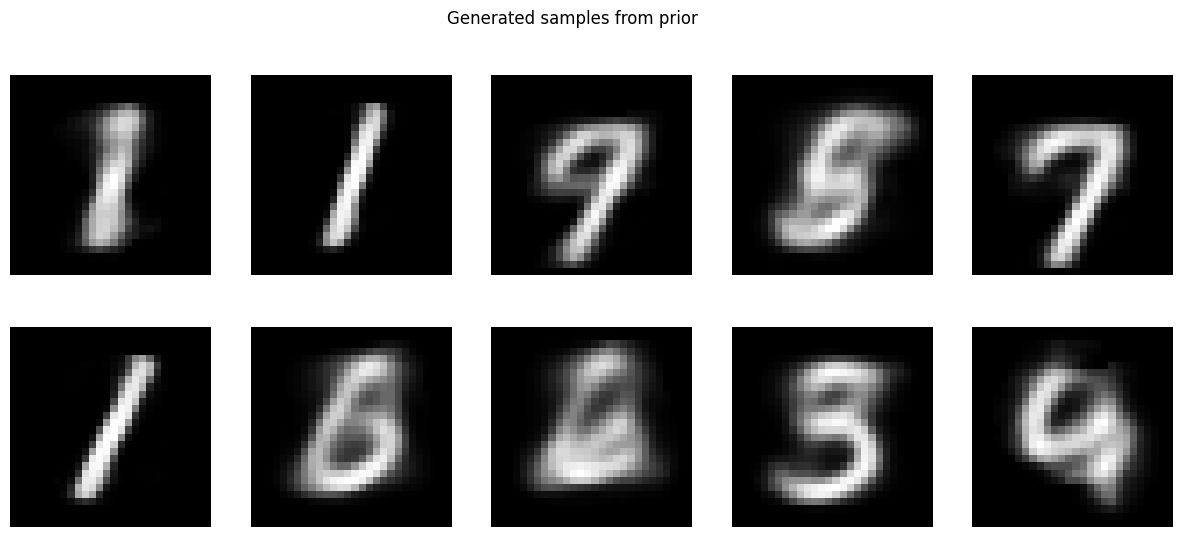

In [109]:
#
generate_samples_from_prior(vae_MNIST.decoder, 2, 10, device, n_row = 2, n_col = 5)

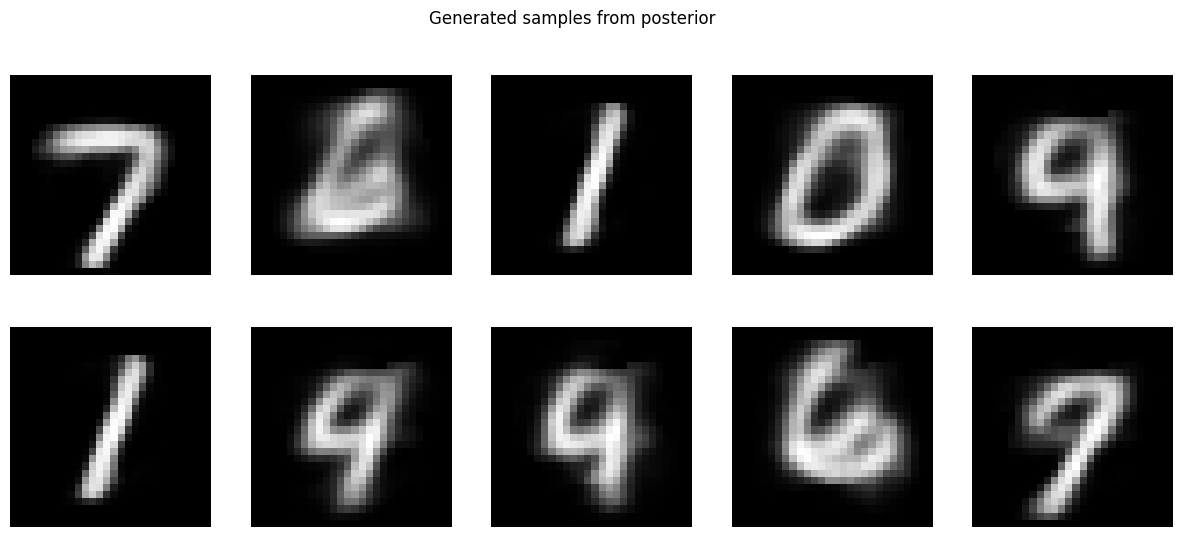

In [110]:
num_samples = 10
data = next(iter(test_dataloader_MNIST))[0][:num_samples]

generate_samples_from_posterior(vae_MNIST, data, device, n_row=2, n_col=5)

## Analyse sur la dimension de l'espace latent

In [111]:
vae_FMNIST = VAutoEncoder(28*28, 20).to(device) # Dimension de l'espace latent == 20
dataloader = train_dataloader
optimizer = optim.Adam(vae_FMNIST.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
  print("--------------------------")
  print(f"Epoch {epoch}")
  train_vae(vae_FMNIST, dataloader, optimizer, loss_fn, device ,epoch)

--------------------------
Epoch 0
Epoch: 0 [0/60000 (0%)]	Loss: 137.227417
Epoch: 0 [6400/60000 (11%)]	Loss: 40.559639
Epoch: 0 [12800/60000 (21%)]	Loss: 35.567154
Epoch: 0 [19200/60000 (32%)]	Loss: 31.925762
Epoch: 0 [25600/60000 (43%)]	Loss: 35.207687
Epoch: 0 [32000/60000 (53%)]	Loss: 32.110756
Epoch: 0 [38400/60000 (64%)]	Loss: 29.206533
Epoch: 0 [44800/60000 (75%)]	Loss: 29.594196
Epoch: 0 [51200/60000 (85%)]	Loss: 30.066664
Epoch: 0 [57600/60000 (96%)]	Loss: 28.818039
Average Loss: 35.9306
--------------------------
Epoch 1
Epoch: 1 [0/60000 (0%)]	Loss: 30.063419
Epoch: 1 [6400/60000 (11%)]	Loss: 28.909592
Epoch: 1 [12800/60000 (21%)]	Loss: 28.921749
Epoch: 1 [19200/60000 (32%)]	Loss: 27.944397
Epoch: 1 [25600/60000 (43%)]	Loss: 29.711063
Epoch: 1 [32000/60000 (53%)]	Loss: 30.060186
Epoch: 1 [38400/60000 (64%)]	Loss: 27.598545
Epoch: 1 [44800/60000 (75%)]	Loss: 27.741615
Epoch: 1 [51200/60000 (85%)]	Loss: 27.525173
Epoch: 1 [57600/60000 (96%)]	Loss: 27.320339
Average Loss: 28.96

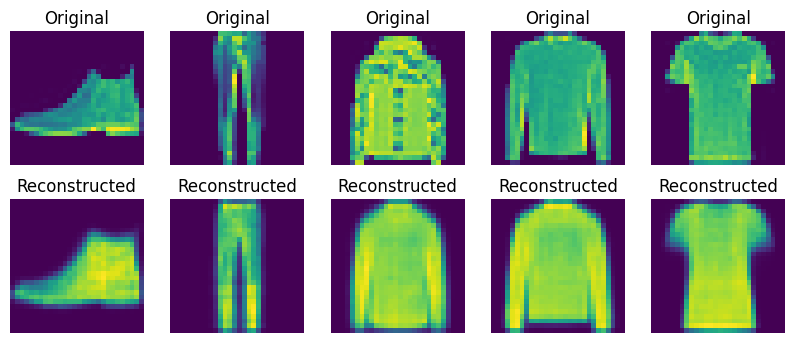

In [112]:
visualize_reconstructions(vae_FMNIST, test_dataloader)

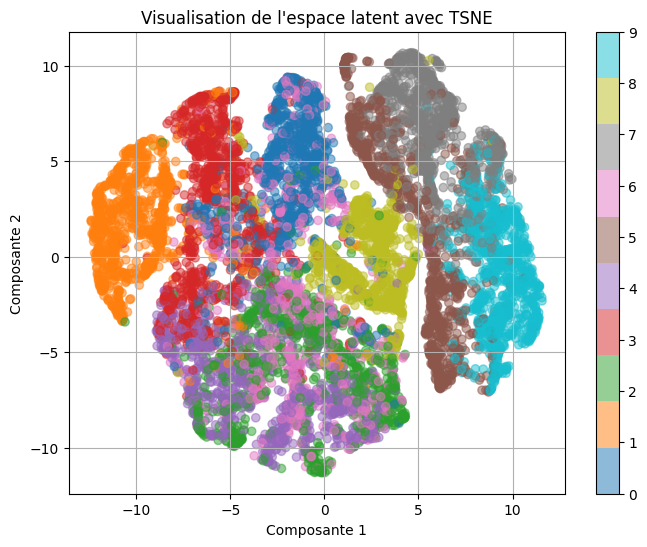

In [115]:
visualize_latent_space(vae_FMNIST, test_dataloader, device, method='tsne')

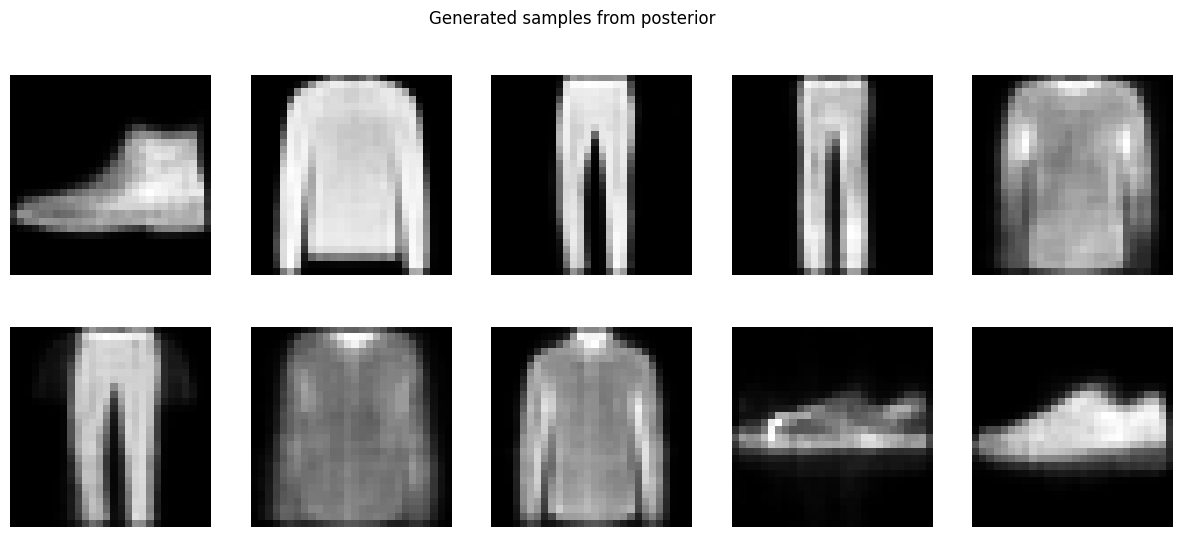

In [114]:
num_samples = 10
data = next(iter(test_dataloader))[0][:num_samples]

generate_samples_from_posterior(vae_FMNIST, data, device, n_row=2, n_col=5)

### Commentaire:
 Une dimension de l'espace latent plus grande offre plus de capacité au modèle pour capturer des caractéristiques complexes et des variations subtiles des données. Cela aide à améliorer la précision de la reconstruction et permet au modèle de générer des échantillons plus diversifiés et réalistes. \\
 Avec plus de dimensions, il est plus facile pour le modèle de séparer différents types de données dans l'espace latent, comme le montrent les clusters bien définis dans la visualisation t-SNE.